# CS5814: Assignment 4

## Problem 2

Q-learning is implemented to solve OpenAIs fozen lake environment.

A custom environment layout is used and described within the code.

Information on the environment is available here: https://gym.openai.com/envs/FrozenLake8x8-v0/

## Imports

In [ ]:
import gym
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gym.envs.toy_text.frozen_lake import FrozenLakeEnv
from tqdm import tqdm

## Supporting Functions

In [ ]:
def rand_argmax(b, **kw):
    """ a random tie-breaking argmax"""
    return np.argmax(np.random.random(b.shape) * (b == b.max()), **kw)

In [ ]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0))
    return (cumsum[N:] - cumsum[:-N]) / float(N)

In [ ]:
def display_grid(state_array):
    """
    Formats the array into a  grid (used for visual interpretation)
    """

    actions = np.array([symbol_dict[action] for action in np.argmax(state_array, axis=0)]).reshape(5, 5)

    values = np.array([value for value in np.max(state_array, axis=0)]).reshape(5, 5)

    print("\nSample policy table:")
    print(actions)
    print("\n")
    policymap2d(actions, values)

    print("\nSample value table:")
    print(values)
    print("\n")
    heatmap2d(values)


In [ ]:
def policymap2d(arr, c_arr):
    #Heatmap generation code

    arr = arr.reshape(5, 5)
    c_arr = c_arr.reshape(5, 5)

    plt.figure(figsize=(8,6))
    plt.imshow(c_arr, cmap='coolwarm')
    plt.colorbar()
    for (j, i), label in np.ndenumerate(arr):
        plt.text(i, j, label, ha='center', va='center', fontsize= 'xx-large')

    plt.axis('off')
    plt.show()

In [ ]:
def heatmap2d(arr):
    #Heatmap generation code

    arr = arr.reshape(5, 5)

    plt.figure(figsize=(8,6))
    plt.imshow(arr, cmap='coolwarm')
    plt.colorbar()
    for (j, i), label in np.ndenumerate(arr):
        label = "{:.5f}".format(label)
        plt.text(i, j, label, ha='center', va='center')

    plt.axis('off')
    plt.show()

In [ ]:
symbol_dict = {3: "↑", 1: "↓", 0: "←", 2: "→"}

## Q-learning helper functions

In [ ]:
def epsilon_greedy_policy(state, q_table, epsilon=0.01):
    if np.random.random() < epsilon:
        action = random.randint(0, 3)
    else:
        action = rand_argmax(q_table[:, state])  # Choose the action with largest Q-value (state value)
    return action


In [ ]:
def create_q_table(rows=5, cols=5):
    """ generate Q Table"""

    # initialize the q_table with all zeros for each state and action
    q_table = np.zeros((4, cols * rows))

    return q_table

In [ ]:
def get_max_state_value(state, q_table):
    """ Determine the maximum value state based on the current state and Q table"""

    state_action = q_table[:, int(state)]
    maximum_state_value = np.amax(state_action)  # return the state value with for the highest action
    return maximum_state_value

In [ ]:
def iteration_decay(episode):
    """Simple function to decay epsilon based on episode number"""

    episode_end = 500
    start_rate = 0.2
    return max(((-start_rate/episode_end)*(episode+1)) + start_rate, 0)

## Q-learning


In [ ]:
def Q_learning(env, alpha, gamma, episodes, epsilon_func, epsilon_override=None):
    """
    Complete a run of Q_learning
    :param name: OpenAI environment name
    :param alpha: learning rate
    :param gamma: decay rate
    :param episodes: episodes to run
    :param epsilon_func: function defining how epsilon is decayed
    :param epsilon_override: override for epsilon (if a constant value is to be used)
    :return: reward_cum_array (list of cumulative rewards for each episode)
    :return: policy - greedy policy based on final Q table (populated with arrows showing direction)
    """

    env.reset()
    q_table = create_q_table()
    reward_cum_array = []
    delta_array = []
    epsilon_array = []

    for episode in tqdm(range(episodes)):

        reward_cum = 0
        state = env.reset()
        for _ in range(100):

            epsilon = epsilon_override if epsilon_override is not None else epsilon_func(episode)

            action = epsilon_greedy_policy(state, q_table=q_table, epsilon=epsilon)

            # Take action, observe rewards
            new_state, reward, done, info = env.step(action)

            next_state_value = get_max_state_value(new_state, q_table=q_table)

            target = reward + gamma * next_state_value

            reward_cum += reward

            # Update Q table:
            updated_q_value = (1-alpha) * q_table[action, state] + alpha * target
            old_q_value = q_table[action, state]
            q_table[action, state] = updated_q_value

            state = new_state

            # Convergence check
            delta_array.append(abs(updated_q_value-old_q_value))
            if max(delta_array[-2000:]) < 1e-4 and len(delta_array) > 2000:
                print("\nConverged after {} updates, {} episodes".format(len(delta_array), episode))
                env.close()

                # Plotting epsilon decay
                plt.plot(epsilon_array)
                plt.xlabel('Episode')
                plt.ylabel('Epsilon')
                plt.grid()
                plt.show()

                return reward_cum_array, q_table  # generate_policy(q_table)

            # End conditions
            if done:
                # Final state reached
                break

        reward_cum_array.append(reward_cum)
        epsilon_array.append(epsilon)

    env.close()
    print("Failed to converge")
    return reward_cum_array, q_table #generate_policy(q_table)

## Training configuration

In [ ]:
def run(run_count=1):

    map_layout = ['SFHFF', 'FHFFF', 'FFFHF', 'FFFFH', 'HFFFG']

    slippy = False
    env = FrozenLakeEnv(desc=map_layout, is_slippery=slippy)


    env.reset()
    alpha = 0.5
    gamma = 0.6

    reward_ts_list = []
    policy_table = []

    for _run in range(run_count):
        reward_ts, policy_table = Q_learning(env=env,
                                             alpha=alpha,
                                             gamma=gamma,
                                             episodes=5000,
                                             epsilon_func=iteration_decay,
                                             epsilon_override=None)

    print("\nSuccess rate over final 1000 episodes : {:.2f}%\n".format(100*np.average(reward_ts[-1000:])))
    display_grid(policy_table)

 12%|█▏        | 620/5000 [00:00<00:04, 1093.17it/s]


Converged after 5472 updates, 704 episodes


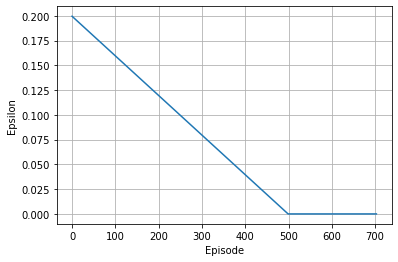

 14%|█▍        | 704/5000 [00:00<00:05, 782.39it/s] 



Success rate over final 1000 episodes : 68.47%


Sample policy table:
[['↓' '←' '←' '←' '←']
 ['↓' '←' '←' '←' '←']
 ['→' '↓' '←' '←' '←']
 ['↑' '→' '→' '↓' '←']
 ['←' '↑' '→' '→' '←']]




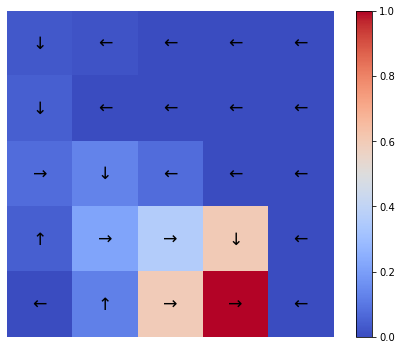


Sample value table:
[[0.0279936  0.01626336 0.         0.         0.        ]
 [0.046656   0.         0.         0.         0.        ]
 [0.07776    0.1296     0.07641923 0.         0.        ]
 [0.04647373 0.216      0.36       0.6        0.        ]
 [0.         0.12452644 0.5961914  1.         0.        ]]




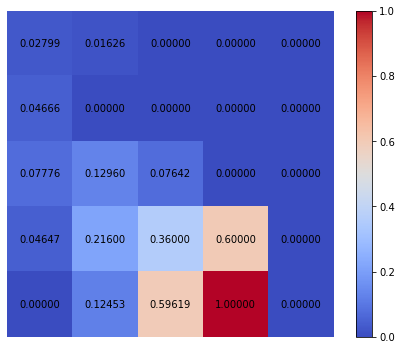

In [ ]:
run(run_count=1)